## Set up

In [43]:
import pickle
from pathlib import Path

import keras as tfk
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.data import Dataset as tfds

sns.set_theme()

In [57]:
EXPERIMENT = "45-fine_tuning"
EXPERIMENT_DIR = Path().absolute().parent / "results" / EXPERIMENT

MODEL_PATH = EXPERIMENT_DIR / "model.keras"
HISTORY_PATH = EXPERIMENT_DIR / "history.pkl"
HISTORIES_PATH = EXPERIMENT_DIR / "histories.pkl"
TRAIN_PREDICTIONS_PATH = EXPERIMENT_DIR / "train_predictions.npy"
VAL_PREDICTIONS_PATH = EXPERIMENT_DIR / "val_predictions.npy"

### Load model

In [45]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_3, built=True>

In [46]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 96, 96, 3)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,559,448 (51.73 MB)

 Trainable params: 208,584 (814.78 KB)

 Non-trainable params: 12,933,694 (49.34 MB)

 Optimizer params: 417,170 (1.59 MB)

In [47]:
layer_weights: list[np.ndarray] = [
    model.layers[i].weights[0].numpy().flatten()
    for i in (-5, -3, -1)
]

<Axes: >

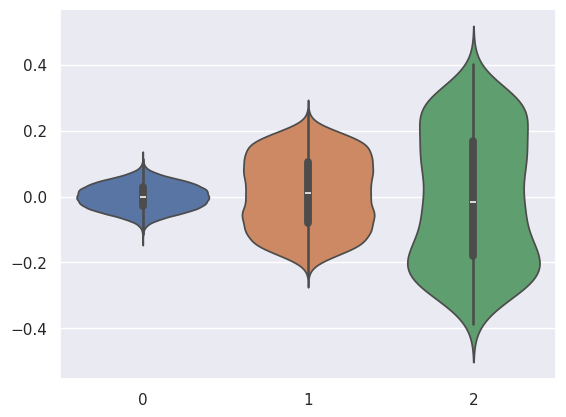

In [48]:
sns.violinplot(layer_weights)

### Load data

In [49]:
BATCH_SIZE = 128
AUGMENTED_DIR = Path().absolute().parent / "data" / "augmented"
TRAIN_TFDS_DIR = AUGMENTED_DIR / "train"
VAL_TFDS_DIR = AUGMENTED_DIR / "val"

train_dataset: tfds = tfds.load(str(TRAIN_TFDS_DIR)).batch(BATCH_SIZE)
val_dataset: tfds = tfds.load(str(VAL_TFDS_DIR)).batch(BATCH_SIZE)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>

### Load predictions

In [50]:
y_train_pred = np.load(TRAIN_PREDICTIONS_PATH)
y_val_pred = np.load(VAL_PREDICTIONS_PATH)

In [51]:
y_train = np.concatenate(
    list(train_dataset.map(lambda _, y: y).as_numpy_iterator())
)
y_val = np.concatenate(
    list(val_dataset.map(lambda _, y: y).as_numpy_iterator())
)

print(y_train.shape)
print(y_val.shape)

(31688, 8)
(5592, 8)


2024-11-16 12:12:43.333770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-16 12:12:43.451717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [53]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [54]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([7, 6, 0, ..., 0, 3, 1]), array([7, 6, 0, ..., 0, 3, 1])),
 'val': (array([2, 3, 7, ..., 5, 0, 2]), array([2, 3, 7, ..., 5, 0, 2]))}

### Load history

In [71]:
if HISTORY_PATH.exists():
    with HISTORY_PATH.open("rb") as f:
        history: tfk.callbacks.History = pickle.load(f)
        history_backbone = None
elif HISTORIES_PATH.exists():
    with HISTORIES_PATH.open("rb") as f:
        histories: list[tfk.callbacks.History] = pickle.load(f)
        history = histories[0]
        history_backbone = histories[1]

history_df = pd.DataFrame(history.history)
f1_df = history_df.filter(like="f1_score")
history_df = history_df[history_df.columns.difference(f1_df.columns)]
history_df

,accuracy,learning_rate,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.590097,0.0001,1.164729,0.821696,0.374337,0.782189,0.838400,0.950207,0.491416
1,0.785786,0.0001,0.620965,0.867608,0.700044,0.860694,0.448187,0.915412,0.793455
2,0.832397,0.0001,0.486150,0.885467,0.778528,0.882868,0.354450,0.919683,0.849785
3,0.852499,0.0001,0.424569,0.895145,0.812263,0.894671,0.316295,0.923004,0.870350
4,0.867836,0.0001,0.380693,0.903121,0.834606,0.907189,0.284519,0.930821,0.887876
5,0.879702,0.0001,0.344664,0.909695,0.851016,0.914521,0.262594,0.931425,0.896280
6,0.885951,0.0001,0.325097,0.914042,0.861746,0.915236,0.251257,0.931405,0.898426
7,0.893146,0.0001,0.302779,0.918681,0.870613,0.917918,0.237271,0.934074,0.902003
8,0.900625,0.0001,0.283982,0.924361,0.878913,0.922747,0.228795,0.937615,0.908441
9,0.905769,0.0001,0.269532,0.927917,0.886014,0.924177,0.222808,0.936674,0.912554


## Analyse

### History

In [72]:
molten_history = history_df.reset_index().melt(id_vars="index")
molten_history["val"] = molten_history["variable"].str.contains("val_")
molten_history["variable"] = molten_history["variable"].str.replace("val_", "")
molten_history

,index,variable,value,val
0,0,accuracy,0.590097,False
1,1,accuracy,0.785786,False
2,2,accuracy,0.832397,False
3,3,accuracy,0.852499,False
4,4,accuracy,0.867836,False
...,...,...,...,...
130,10,recall,0.918455,True
131,11,recall,0.915951,True
132,12,recall,0.920780,True
133,13,recall,0.922568,True


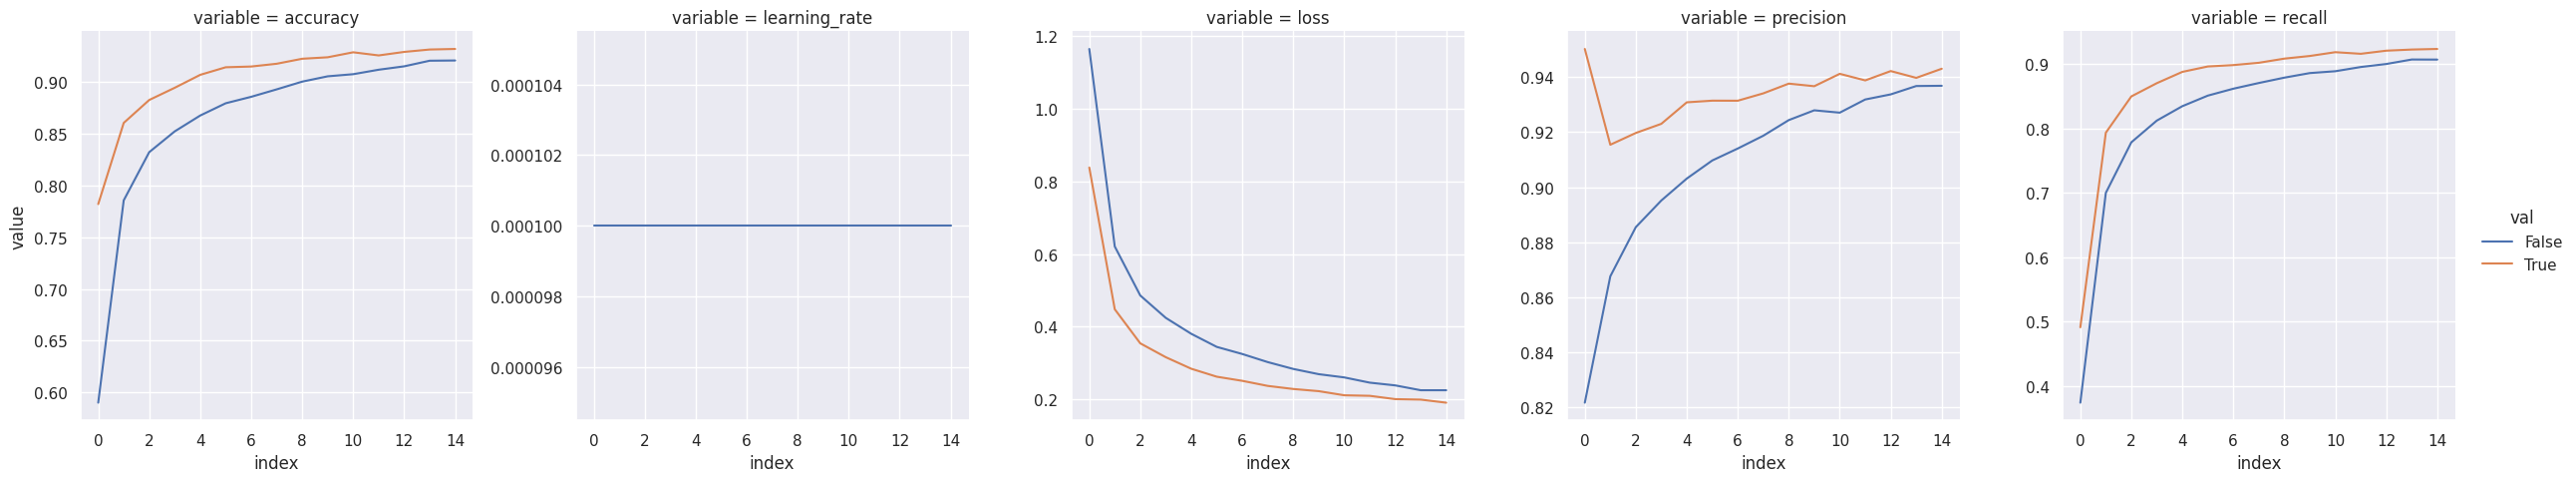

In [73]:
sns.relplot(
    molten_history,
    x="index",
    y="value",
    col="variable",
    hue="val",
    facet_kws={"sharey": False},
    kind="line",
)

### Classification metrics

In [65]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3962
           1       1.00      1.00      1.00      3962
           2       1.00      0.99      1.00      3960
           3       0.99      0.97      0.98      3960
           4       0.99      1.00      1.00      3960
           5       0.98      1.00      0.99      3962
           6       0.99      0.99      0.99      3960
           7       1.00      1.00      1.00      3962

    accuracy                           0.99     31688
   macro avg       0.99      0.99      0.99     31688
weighted avg       0.99      0.99      0.99     31688


val
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       698
           1       0.99      0.97      0.98       698
           2       0.97      0.97      0.97       700
           3       0.93      0.88      0.90       700
           4       0.96      0.98      0.97       700
           5 

### Confusion matrices

In [66]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 19.049999999999997, 'Predicted')

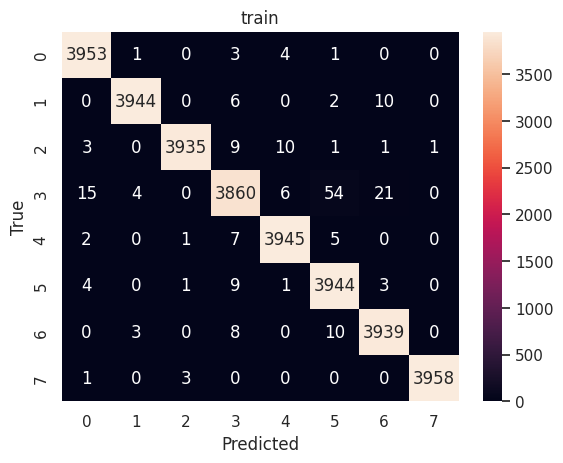

In [67]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

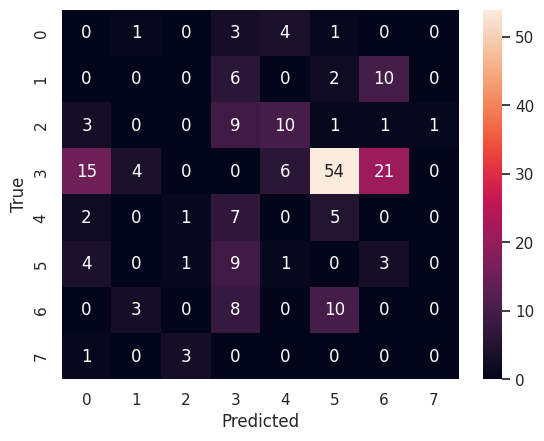

In [68]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 19.049999999999997, 'Predicted')

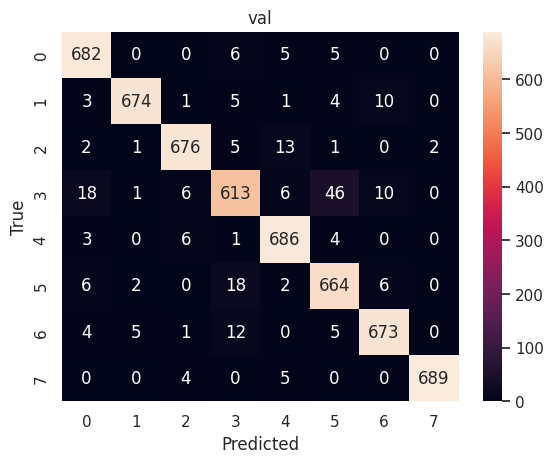

In [69]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

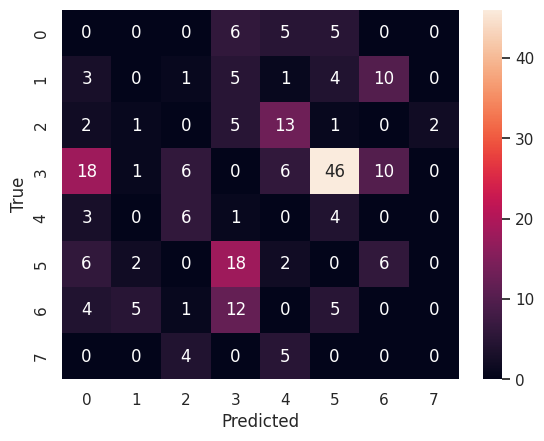

In [70]:
confusion_diag_zero(*outputs["val"])